## Drive işlemleri ve yüklemeler

In [ ]:
import os
# connect with google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install pytorch-ignite
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

## Dosya işlemleri

In [ ]:
data_dir = '/content/drive/My Drive/DEM DATA/turkiye_dtm'
train_dir = '/content/drive/My Drive/DEM DATA/train'
test_dir = '/content/drive/My Drive/DEM DATA/test'

In [ ]:
import os
import rasterio
from glob import glob

def calculate_global_min_max(data_dir):
    min_val = float('inf')
    max_val = float('-inf')

    for tiff_file in glob(os.path.join(data_dir, '*.tif')):
        with rasterio.open(tiff_file) as src:
            array = src.read(1)
            min_val = min(min_val, array.min())
            max_val = max(max_val, array.max())

    return min_val, max_val

def normalize_and_save(array, min_val, max_val, save_path):
    normalized_array = (array - min_val) / (max_val - min_val) * 2 - 1  # -1 ile 1 arasında normalizasyon
    normalized_img = Image.fromarray((normalized_array * 255).astype(np.uint8))
    normalized_img.save(save_path)

# Global min ve max değerlerini hesapla
global_min, global_max = calculate_global_min_max(data_dir)

# Normalizasyon işlemi ve kaydetme
for tiff_file in glob(os.path.join(data_dir, '*.tif')):
    with rasterio.open(tiff_file) as src:
        array = src.read(1)
        filename = os.path.basename(tiff_file).split('.')[0]
        save_path = os.path.join('/content/drive/My Drive/DEM DATA/normalized', f"{filename}_normalized.tif")
        normalize_and_save(array, global_min, global_max, save_path)

print("Normalizasyon işlemi tamamlandı.")


Normalizasyon işlemi tamamlandı.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import rasterio
from tqdm import tqdm
import shutil
from PIL import Image

data_dir = '/content/drive/My Drive/DEM DATA/normalized'

# Eğer klasörler yoksa oluştur
for folder in [train_dir, test_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

def split_and_save(array, filename, split_size=300, train_ratio=0.8):
    """
    Büyük DEM array'ini küçük parçalara böler ve rastgele eğitim ve test olarak ayırır.
    """
    # Output boyutlarını hesapla
    num_rows, num_cols = array.shape
    for row in range(0, num_rows, split_size):
        for col in range(0, num_cols, split_size):
            # Array'den bir parça al
            split = array[row:row+split_size, col:col+split_size]
            # Eğer parça tam boyutta değilse, döngüye devam et
            if split.shape[0] != split_size or split.shape[1] != split_size:
                continue
            # Parçayı kaydet
            split_img = Image.fromarray(split)
            # Eğitim ve test olarak ayır
            if np.random.rand() < train_ratio:
                split_img.save(os.path.join(train_dir, f"{filename}_{row}_{col}.tif"))
            else:
                split_img.save(os.path.join(test_dir, f"{filename}_{row}_{col}.tif"))

# Tüm tiff dosyaları için işlemi yap
for tiff_file in tqdm(sorted(glob(os.path.join(data_dir, '*.tif')))):
    with rasterio.open(tiff_file) as src:
        array = src.read(1)  # Sadece ilk kanalı oku
        filename = os.path.basename(tiff_file).split('.')[0]  # Dosya ismini al
        split_and_save(array, filename)

print("İşlem tamamlandı.")


        # print(array.shape) ## 3601x3601 pixels
        # If we divide these to 300x300 pixels 12x12 = 144 pictures (144 pictures) in total
        # Austria dtm has 2000 pictures.
        # I think I need 2000/12 = 160 parcels
        # Maybe I can lower the pixels.

        # 128X128 pixel yapmak da mantıklı olabilir.
        # Bölümlendirmeyi yaparken overlap tekniğini kullan.
        # Bunların çözünürlük 1 arc olduğu için 30m'ye tekabül ediyor.


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

İşlem tamamlandı.


In [ ]:
import numpy as np
# Eğitim klasöründeki dosya sayısını bul
num_files = [name for name in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, name))]

num_files_np = np.array(num_files)
len(np.unique(num_files_np))

1286

## Tools

In [ ]:
import torch
import ignite.metrics

#from ignite.metrics import PSNR,SSIM
from ignite.engine import Engine

CHECKPOINT_GEN = "/content/drive/My Drive/DEM DATA/turkiye_dtm/gen3.pth.tar"
CHECKPOINT_DISC = "/content/drive/My Drive/DEM DATA/turkiye_dtm/disc3.pth.tar"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def total_variation(image_in):
    tv_h = torch.sum(torch.abs(image_in[ :, :-1] - image_in[ :, 1:]))
    tv_w = torch.sum(torch.abs(image_in[ :-1, :] - image_in[ 1:, :]))
    tv_loss = tv_h + tv_w
    return tv_loss

def TV_loss(im_batch, weight):
    TV_L = 0.0
    for tv_idx in range(len(im_batch)):
        TV_L = TV_L + total_variation(im_batch[tv_idx,0,:,:])
    TV_L = TV_L/len(im_batch)
    return weight*TV_L


def eval_step(engine, batch):
    return batch

def calculate_error(img1,img2):
    default_evaluator = Engine(eval_step)

    # calculating PSNR
    y1 = img1
    y2 = img2

    psnr = ignite.metrics.PSNR(data_range=1)
    psnr.attach(default_evaluator, 'psnr')
    state1 = default_evaluator.run([[y1,y2]])
    # print(f"PSNR :{state1.metrics['psnr']}")

    # # calculating SSIM
    y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)
    metric = ignite.metrics.SSIM(data_range=1)
    metric.attach(default_evaluator, 'ssim')
    state2 = default_evaluator.run([[y1, y2]])


    # print(f"SSIM : {state2.metrics['ssim']}")
    return state1.metrics['psnr'], state2.metrics['ssim']

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename) # save the progress


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



## Dataset Manipulation operations

In [ ]:
import rasterio

def print_tif_shape(file_path):
    with rasterio.open(file_path) as src:
        array = src.read()  # Tüm bantları oku
        print(f"Shape: {array.shape}")  # (Bant sayısı, Yükseklik, Genişlik)

# Örnek kullanım:
file_path = '/content/drive/My Drive/DEM DATA/austria_dtm/resized_hr_images/407000_460920.tif'  # Örnek dosya yolu
print_tif_shape(file_path)


Shape: (1, 1200, 1200)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
from PIL import Image
import os
from glob import glob

# Kaynak ve hedef klasör yolları
hr_train_dir = '/content/drive/My Drive/DEM DATA/train'
lr_train_dir = '/content/drive/My Drive/DEM DATA/lr_train'
resized_hr_train_dir = '/content/drive/My Drive/DEM DATA/resized_hr_train'

# Hedef klasörler yoksa oluştur
for folder in [lr_train_dir, resized_hr_train_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

def process_images(hr_dir, lr_dir, resized_hr_dir):
    # HR görüntüler üzerinde dön
    for hr_image_path in glob(os.path.join(hr_dir, '*.tif')):
        with Image.open(hr_image_path) as hr_image:
            # HR görüntüyü direkt LR olarak aynı boyutta kaydet (örneğin, interpolasyon yöntemiyle düşük çözünürlüklü hale getirildikten sonra)
            lr_image = hr_image.resize((300, 300), Image.ANTIALIAS)  # Burada aslında boyut değişmiyor, örnek amaçlıdır.
            lr_image_save_path = os.path.join(lr_dir, os.path.basename(hr_image_path))
            lr_image.save(lr_image_save_path)

            # HR görüntüyü 1200x1200 boyuta yeniden boyutlandır
            resized_hr_image = hr_image.resize((1200, 1200), Image.BICUBIC)
            resized_hr_image_save_path = os.path.join(resized_hr_dir, os.path.basename(hr_image_path))
            resized_hr_image.save(resized_hr_image_save_path)

# İşlemleri başlat
process_images(hr_train_dir, lr_train_dir, resized_hr_train_dir)

print("HR'den LR'ye dönüşüm ve HR'lerin yeniden boyutlandırılması tamamlandı.")


<ipython-input-38-e6560b5ef597>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  lr_image = hr_image.resize((300, 300), Image.ANTIALIAS)  # Burada aslında boyut değişmiyor, örnek amaçlıdır.


HR'den LR'ye dönüşüm ve HR'lerin yeniden boyutlandırılması tamamlandı.


In [ ]:
# Eğitim klasöründeki dosya sayısını bul
num_files = [name for name in os.listdir(hr_train_dir) if os.path.isfile(os.path.join(hr_train_dir, name))]

num_files_np = np.array(num_files)
len(np.unique(num_files_np))

1286

In [ ]:
from PIL import Image
import os
from glob import glob

# Kaynak ve hedef klasör yolları
hr_train_dir = '/content/drive/My Drive/DEM DATA/test'
lr_train_dir = '/content/drive/My Drive/DEM DATA/lr_test'
resized_hr_train_dir = '/content/drive/My Drive/DEM DATA/resized_hr_test'

# Hedef klasörler yoksa oluştur
for folder in [lr_train_dir, resized_hr_train_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

def process_images(hr_dir, lr_dir, resized_hr_dir):
    # HR görüntüler üzerinde dön
    for hr_image_path in glob(os.path.join(hr_dir, '*.tif')):
        with Image.open(hr_image_path) as hr_image:
            # HR görüntüyü direkt LR olarak aynı boyutta kaydet (örneğin, interpolasyon yöntemiyle düşük çözünürlüklü hale getirildikten sonra)
            lr_image = hr_image.resize((300, 300), Image.ANTIALIAS)  # Burada aslında boyut değişmiyor, örnek amaçlıdır.
            lr_image_save_path = os.path.join(lr_dir, os.path.basename(hr_image_path))
            lr_image.save(lr_image_save_path)

            # HR görüntüyü 1200x1200 boyuta yeniden boyutlandır
            resized_hr_image = hr_image.resize((1200, 1200), Image.BICUBIC)
            resized_hr_image_save_path = os.path.join(resized_hr_dir, os.path.basename(hr_image_path))
            resized_hr_image.save(resized_hr_image_save_path)

# İşlemleri başlat
process_images(hr_train_dir, lr_train_dir, resized_hr_train_dir)

print("HR'den LR'ye dönüşüm ve HR'lerin yeniden boyutlandırılması tamamlandı.")


<ipython-input-42-48256300b2f4>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  lr_image = hr_image.resize((300, 300), Image.ANTIALIAS)  # Burada aslında boyut değişmiyor, örnek amaçlıdır.


HR'den LR'ye dönüşüm ve HR'lerin yeniden boyutlandırılması tamamlandı.


In [ ]:
# Eğitim klasöründeki dosya sayısını bul
num_files = [name for name in os.listdir(lr_train_dir) if os.path.isfile(os.path.join(lr_train_dir, name))]

num_files_np = np.array(num_files)
len(np.unique(num_files_np))

298

## Dataset operations

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import rasterio
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform

        # List all files in the resized HR directory
        self.hr_filepath = sorted(glob(os.path.join(self.hr_dir, '*.tif')))[:100]
        self.lr_filepath = sorted(glob(os.path.join(self.lr_dir, '*.tif')))[:100]

    def __len__(self):
        return min(len(self.lr_filepath), len(self.hr_filepath))

    def __getitem__(self, index):
        with rasterio.open(self.lr_filepath[index]) as src:
            lr = src.read(1)  # numpy array
        with rasterio.open(self.hr_filepath[index]) as src:
            hr = src.read(1)

        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)

        return lr, hr

# Define your transform function
transform = transforms.Compose([transforms.ToTensor()])



In [ ]:

# Update the dataset creation with the transform
train_set = CustomDataset(lr_dir='/content/drive/My Drive/DEM DATA/lr_train',
                          hr_dir='/content/drive/My Drive/DEM DATA/resized_hr_train',
                          transform=transform)
test_set = CustomDataset(lr_dir='/content/drive/My Drive/DEM DATA/lr_test',
                         hr_dir='/content/drive/My Drive/DEM DATA/resized_hr_test',
                         transform=transform)
print(len(train_set))
print(len(test_set))
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

100
100


## Discriminator

In [ ]:
import torch
import torch.nn as nn
import torchvision


class Blocks(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Blocks, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels, features):

    super(Discriminator, self).__init__()

    self.first_layer= nn.Sequential(
        nn.Conv2d(in_channels, features, 3, 2 ,1),
        nn.LeakyReLU(0.2),
    )
    self.Block1 = Blocks(features, features*2, stride=2)
    self.Block2 = Blocks(features*2, features*2, stride=1)
    self.Block3 = Blocks(features*2, features*4, stride=2)
    self.Block4 = Blocks(features*4, features*4, stride=1)
    self.Block5 = Blocks(features*4, features*8, stride=2)
    self.Block6 = Blocks(features*8, features*8, stride=1)
    self.Block7 = Blocks(features*8, features*8, stride=2)
    self.Block8 = Blocks(features*8, features*8, stride=2)

    self.Block9 = nn.Sequential(
        nn.Conv2d(features*8, features*4, 3, 2, 1),

        nn.LeakyReLU(0.2),
    )


    self.final_layer = nn.Sequential(
        nn.Conv2d(features * 4, 1, 3, 2, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    outputs = []

    x =  self.first_layer(x)
    outputs.append(x)
    x =  self.Block1(x)
    outputs.append(x)
    x =  self.Block2(x)
    outputs.append(x)
    x =  self.Block3(x)
    outputs.append(x)
    x =  self.Block4(x)
    outputs.append(x)
    x =  self.Block5(x)
    outputs.append(x)
    x =  self.Block6(x)
    outputs.append(x)
    x =  self.Block7(x)
    outputs.append(x)
    x =  self.Block8(x)
    outputs.append(x)
    x = self.Block9(x)
    outputs.append(x)

    x = self.final_layer(x)
    outputs.append(x)

    return x, outputs

def test():
  x = torch.randn(8,1,128,128)

  disc = Discriminator(1,32)

  out, outputs = disc(x)  # Get all outputs

  for i, output in enumerate(outputs):
      print(f"Layer {i} output shape: {output.shape}")

if __name__ == "__main__":
    test()

Layer 0 output shape: torch.Size([8, 32, 64, 64])
Layer 1 output shape: torch.Size([8, 64, 32, 32])
Layer 2 output shape: torch.Size([8, 64, 16, 16])
Layer 3 output shape: torch.Size([8, 128, 8, 8])
Layer 4 output shape: torch.Size([8, 128, 4, 4])
Layer 5 output shape: torch.Size([8, 256, 2, 2])
Layer 6 output shape: torch.Size([8, 256, 1, 1])
Layer 7 output shape: torch.Size([8, 256, 1, 1])
Layer 8 output shape: torch.Size([8, 256, 1, 1])
Layer 9 output shape: torch.Size([8, 128, 1, 1])
Layer 10 output shape: torch.Size([8, 1, 1, 1])


## Generator

In [ ]:
import torch
import torch.nn as nn
import torchvision

class CNNBlocks(nn.Module):
  def __init__(self, in_channels ):
    super(CNNBlocks, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, in_channels, 3, 1, 1),
        nn.BatchNorm2d(in_channels),
        nn.PReLU(),
        nn.Conv2d(in_channels, in_channels, 3, 1, 1),
        nn.BatchNorm2d(in_channels),
    )

  def forward(self, x):
      return self.conv(x) + x # Elementwise part in the Residual Block


class PixelShuffle(nn.Module):
  def __init__(self, in_channels, out_channels, upscale_factor):
    super(PixelShuffle, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels, 3, 1, 1),
        nn.PixelShuffle(upscale_factor),
        nn.PReLU(),
    )

  def forward(self,x):
    return self.conv(x)



class Generator(nn.Module):
  def __init__(self, in_channels, features):
    super(Generator, self).__init__()
    self.first_layer = nn.Sequential(
        nn.Conv2d(in_channels, features, 3, 1, 1),
        nn.PReLU(),
    )
    self.RB1 = CNNBlocks(features)
    self.RB2 = CNNBlocks(features)
    self.RB3 = CNNBlocks(features)
    self.RB4 = CNNBlocks(features)

    self.mid_layer = nn.Sequential(
        nn.Conv2d(features, features*4, 3, 1, 1),
        nn.PReLU(),
    )
    self.PS1 = PixelShuffle(features*4, features*8,2)
    self.PS2 = PixelShuffle(features*2, features*4,2)

    self.final_layer = nn.Sequential(
        nn.Conv2d(features, in_channels, 3, 1, 1),
        nn.Tanh(),
    )


  def forward(self, x):
    x1 = self.first_layer(x)
    x2 = self.RB1(x1)
    x3 = self.RB2(x2)
    x4 = self.RB3(x3)
    x5 = self.RB4(x4)
    x6 = self.mid_layer(x5 + x1) # last elementwise sum
    x7 = self.PS1(x6)
    x8 = self.PS2(x7)
    return self.final_layer(x8)

def test():
  gen = Generator(1, 32)
  x = torch.randn(8,1,128,128)
  out = gen(x)
  print(out.shape)


if __name__ == "__main__":
    test()

torch.Size([8, 1, 512, 512])


## Training

In [ ]:
!pip install pytorch_msssim

In [ ]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

# SSIM ve MS-SSIM için loss fonksiyonlarını tanımlayın
def ssim_loss(y_true, y_pred):
    return 1 - ssim(y_true, y_pred, data_range=1, size_average=True)  # 1 ile 0 arasında

def ms_ssim_loss(y_true, y_pred):
    return 1 - ms_ssim(y_true, y_pred, data_range=1, size_average=True)  # 1 ile 0 arasında

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
import os
import wandb
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from glob import glob
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import wandb
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_msssim

LOAD_MODEL = False
SAVE_MODEL = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

gen = Generator(1, 32).to(DEVICE) # Generator
disc = Discriminator(1, 32).to(DEVICE) # Discriminator

# optimizer for generator and disciriminator, which is responsible for updating
# the weights of the models to minize its loss during training
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001) # learning rate can be changed
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.001) # learning rate can be changed


# Function to post-process and visualize
def postprocess_and_display1(tensor):
    tensor = tensor.squeeze().detach().cpu().numpy()  # Convert to numpy array
    tensor = (tensor + 1) / 2  # Rescale back to [0, 1] if the output was in [-1, 1]
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()



wandb.init(project="sr-gan-64-100-images")

num_epochs = 25
num_train_batches = float(len(train_loader))

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN,
        gen,
        opt_gen,
        0.01,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, 0.01,
    )

for epoch in range(num_epochs):

    print(f"Epoch {epoch}: ", end ="") # epoch number

    # Generator Loss
    G_adversarial_loss = 0
    G_reconstruction_loss = 0
    G_total_loss = 0

    # Discriminator Loss
    D_adversarial_loss = 0

    gen.train() # This a function specialized with PyTorch

    # There are 10 images in each batch and there are 100 images in total this loop will work 10 times

    for batch, (lr, hr) in enumerate(train_loader):
      print(batch)
      for p in disc.parameters():
            p.requires_grad = False # Discriminator's parameters are frozen to avoid updating them during Generator training.
        #training generator
      opt_gen.zero_grad() # Zeroes out the gradients for the generator, avoid mixing gradients from multiple forward passes

      lr_images = lr.to(DEVICE) # For tensor computations
      hr_images = hr.to(DEVICE) # For tensor computations
      lr_images = lr_images.float() # Necessary for network operations in PyTorch

      predicted_hr_images = gen(lr_images) # Generator creates hr images

      postprocess_and_display1(predicted_hr_images[0])

      #print("generator image:")
      #print(f"Min value of tensor {torch.min(predicted_hr_images)} max value for torch: {torch.max(predicted_hr_images)}")
      #print(predicted_hr_images)

      predicted_hr_labels, outputs = disc(predicted_hr_images) # Discriminator outputs its prediction on whether the images are real or fake

      # Adversarial Loss
      # Loss for the Generator based on how well it is able to generate images that are classified as 'real' by discriminator
      gf_loss = F.binary_cross_entropy_with_logits(predicted_hr_labels, torch.ones_like(predicted_hr_labels)) # adversarial loss

      # Reconstruction loss
      # gr_loss = 100*F.l1_loss(predicted_hr_images, hr_images) # L1 loss
      tv_loss = TV_loss(predicted_hr_images, 0.0000005) # Total Variation Loss, encourages spatial smoothness in the generated images.
      gr_loss = 100 * F.mse_loss(predicted_hr_images, hr_images) + tv_loss # L2 loss -> reconstruction loss


      ssim_val = 1 - pytorch_msssim.ssim(predicted_hr_images, hr_images, data_range=1, size_average=True)  # SSIM kaybı
      ms_ssim_val = 1 - ms_ssim(predicted_hr_images, hr_images, data_range=1, size_average=True)  # MS-SSIM kaybı

      # Calculating all losses together.
      g_loss = gf_loss + gr_loss + ssim_val + ms_ssim_val


      # Accumulation of different losses
      G_adversarial_loss += gf_loss.item() # item changes tensor to python scalar for easier handling
      G_reconstruction_loss += gr_loss.item()
      G_total_loss += g_loss.item()

      g_loss.backward() # Backpropagation, which is crucial for effectively updating parameters (weight, bias) during training
      opt_gen.step() # Generator weights are updated

      # save model after the step function

      if SAVE_MODEL:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)


      # training discriminator, removing the freeze
      for p in disc.parameters():
        p.requires_grad = True

      opt_disc.zero_grad() # Resetting gradients for discriminator

      predicted_hr_images = gen(lr_images).detach() # avoid back-propogation for generator
      hr_images = hr_images.float() # real hr images converted to floating point

      adv_hr_real, outputs = disc(hr_images)
      adv_hr_fake, outputs = disc(predicted_hr_images)


      # calculating the disciriminator loss, calculating loss for real images and fake images
      # We don't need to add other losses for this one because discriminator only tries to distiungish between real and fake image
      # It doesn't need other losses to calculate this.
      df_loss = F.binary_cross_entropy_with_logits(adv_hr_real, torch.ones_like(adv_hr_real)) + F.binary_cross_entropy_with_logits(adv_hr_fake, torch.zeros_like(adv_hr_fake))

      # Backpropogation and Updating Weights
      D_adversarial_loss += df_loss.item()
      df_loss.backward() # Computes the gradients of the loss iwth respect to the disc parameters
      opt_disc.step() # update weights of Discriminator

    wandb.log({"G Adversarial Loss": G_adversarial_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Reconstruction Loss": G_reconstruction_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"G Loss Total": G_total_loss/num_train_batches, 'epoch':epoch })
    wandb.log({"D Adversarial Loss": D_adversarial_loss/num_train_batches, 'epoch':epoch })

    torch.cuda.empty_cache()

    #After each epoch, we perform validation
    with torch.inference_mode():
      val_psnr = 0
      val_ssim = 0

      for batch_idx, (lr, hr) in enumerate(train_loader):

        lr = lr.to(DEVICE)
        hr = hr.to(DEVICE)
        lr = lr.float()

        # Forward pass
        predicted_hr = gen(lr)

        min_value = torch.min(predicted_hr).item()
        max_value = torch.max(predicted_hr).item()

        print(f"min {min_value} and max {max_value} values of predicted_hr")

        psnr, ssim = calculate_error(hr, predicted_hr)
        val_psnr += psnr
        val_ssim += ssim

        grid1 = make_grid(lr)
        grid2 = make_grid(hr)
        grid3 = make_grid(predicted_hr)

        grid1 = wandb.Image(grid1, caption="Low Resolution Image")
        grid2 = wandb.Image(grid2, caption="High Resolution Image")
        grid3 = wandb.Image(grid3, caption="Reconstructed High Resolution Image")

        wandb.log({"Original LR": grid1})
        wandb.log({"Original HR": grid2})
        wandb.log({"Reconstruced": grid3})

    val_psnr /= num_train_batches
    val_ssim /= num_train_batches
    wandb.log({"PSNR" : val_psnr, 'epoch':epoch })
    wandb.log({"SSIM" : val_ssim, 'epoch':epoch })
    print(f"PSNR: {val_psnr:.3f} SSIM: {val_ssim:.3f}\n")


=> Loading checkpoint
=> Loading checkpoint
min -0.1527577042579651 and max 0.9811750054359436 values of predicted_hr
Predicted image:


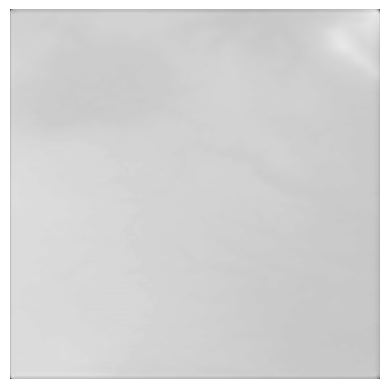

Low resolution image


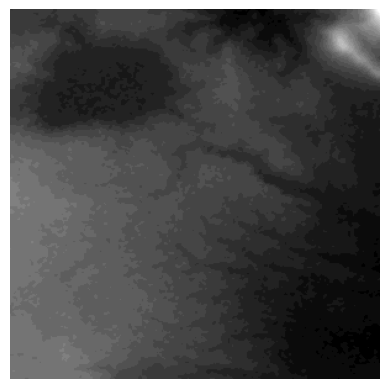

PSNR: 29.710 SSIM: 0.887

Mse loss calue:  0.0030532781966030598 



<ipython-input-17-b2cfd50aa680>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)


min -0.1715434193611145 and max 0.9834111928939819 values of predicted_hr
Predicted image:


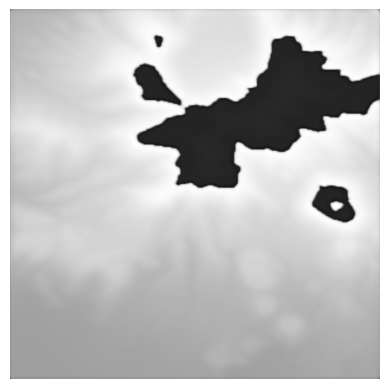

Low resolution image


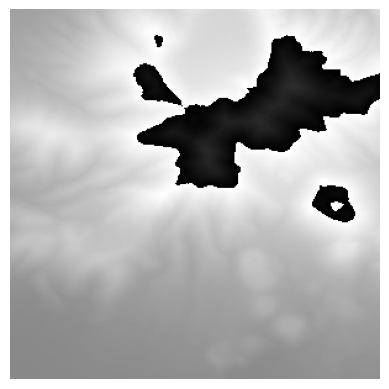

PSNR: 30.332 SSIM: 0.941

Mse loss calue:  0.0012544060591608286 

min 0.08091190457344055 and max 0.9008047580718994 values of predicted_hr
Predicted image:


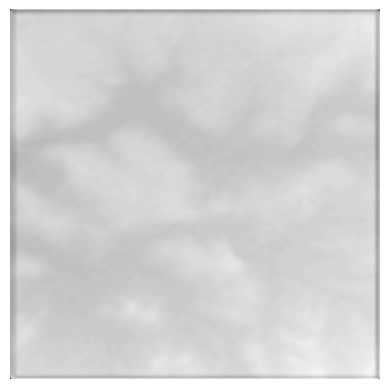

Low resolution image


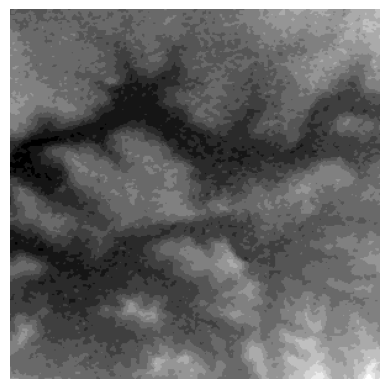

PSNR: 32.427 SSIM: 0.971

Mse loss calue:  0.001017571659758687 

min -0.17141546308994293 and max 0.98105788230896 values of predicted_hr
Predicted image:


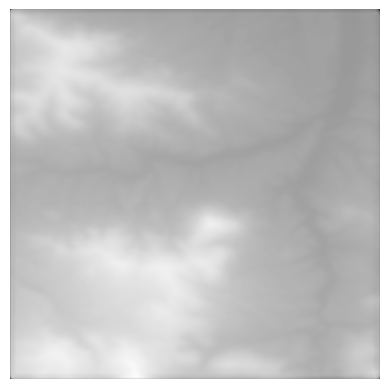

Low resolution image


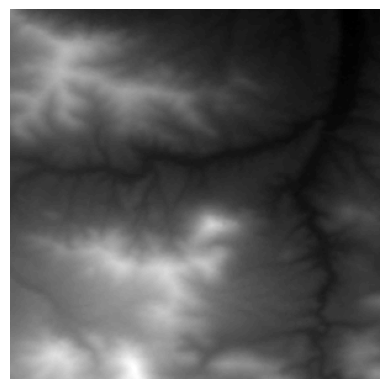

PSNR: 31.296 SSIM: 0.969

Mse loss calue:  0.0009965671924874187 

min -0.016097232699394226 and max 0.9326176643371582 values of predicted_hr
Predicted image:


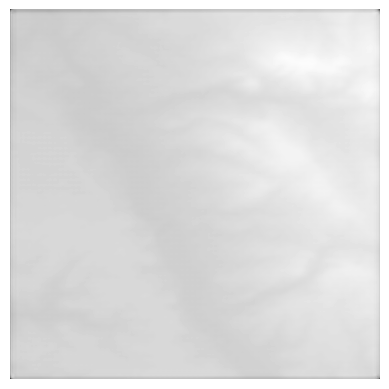

Low resolution image


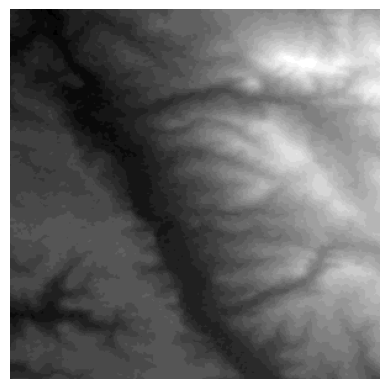

PSNR: 31.551 SSIM: 0.940

Mse loss calue:  0.0016482837963849306 

min -0.1304745227098465 and max 0.9795878529548645 values of predicted_hr
Predicted image:


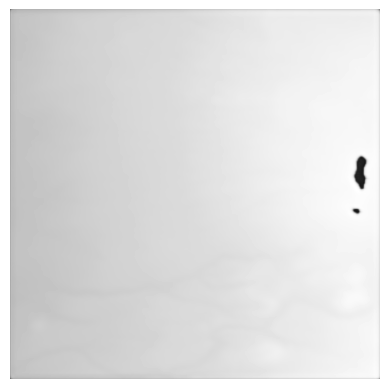

Low resolution image


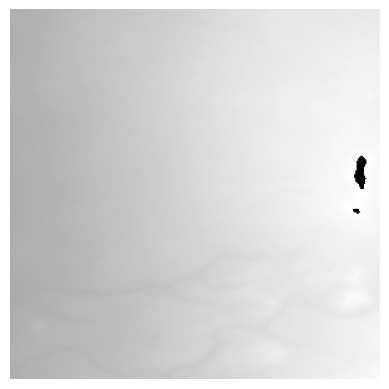

PSNR: 30.029 SSIM: 0.942

Mse loss calue:  0.0017401204677298665 

min -0.14742432534694672 and max 0.9801415801048279 values of predicted_hr
Predicted image:


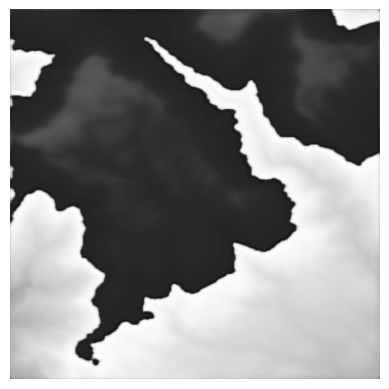

Low resolution image


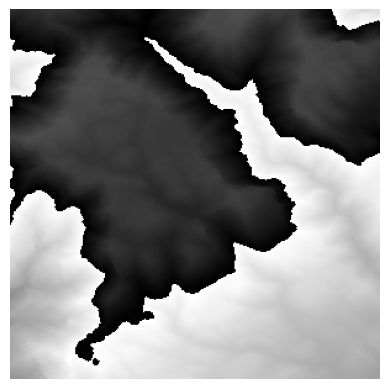

PSNR: 30.534 SSIM: 0.944

Mse loss calue:  0.0020944445859640837 

min -0.1402738243341446 and max 0.979826807975769 values of predicted_hr
Predicted image:


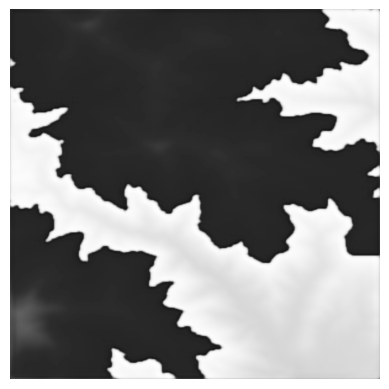

Low resolution image


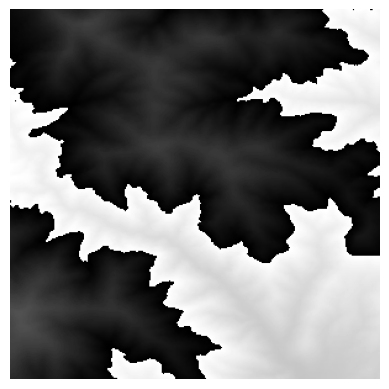

PSNR: 30.933 SSIM: 0.914

Mse loss calue:  0.001657989458180964 

min -0.1755201369524002 and max 0.9809924960136414 values of predicted_hr
Predicted image:


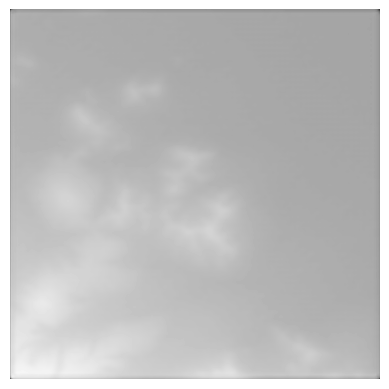

Low resolution image


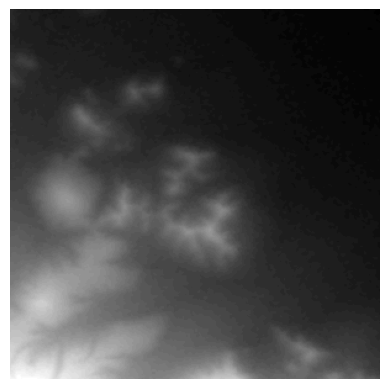

PSNR: 28.404 SSIM: 0.883

Mse loss calue:  0.003932772669941187 

min -0.15091511607170105 and max 0.9824456572532654 values of predicted_hr
Predicted image:


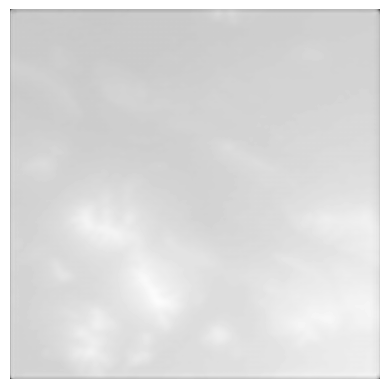

Low resolution image


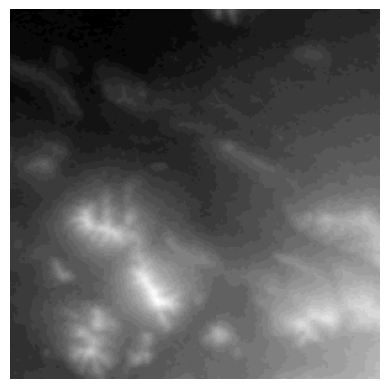

PSNR: 30.996 SSIM: 0.957

Mse loss calue:  0.0009956852300092578 

PSNR: 30.621 SSIM: 0.935
 MSE_LOSS: 0.002



In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from glob import glob
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt


LOAD_MODEL = True
SAVE_MODEL = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(1, 32).to(DEVICE) # Generator
disc = Discriminator(1, 32).to(DEVICE) # Discriminator

# optimizer for generator and disciriminator, which is responsible for updating
# the weights of the models to minize its loss during training
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001) # learning rate can be changed
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.001) # learning rate can be changed

num_epochs = 10
num_train_batches = float(len(train_loader))
num_test_batches = float(len(test_loader))

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN,
        gen,
        opt_gen,
        0.001,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, 0.001,
    )

gen.eval()

# Function to post-process and visualize
def postprocess_and_display(tensor):
    tensor = tensor.squeeze().detach().cpu().numpy()  # Convert to numpy array
    tensor = (tensor + 1) / 2  # Rescale back to [0, 1] if the output was in [-1, 1]
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()


mse_loss = nn.MSELoss()

def calculate_mse_loss(hr, predicted_hr):
    return mse_loss(hr, predicted_hr)

with torch.inference_mode():
    mse_val = 0
    val_psnr = 0
    val_ssim = 0
    for batch, (lr, hr) in enumerate(test_loader):
        lr = lr.to(DEVICE)
        hr = hr.to(DEVICE)
        lr = lr.float()
        predicted_hr = gen(lr)

        min_value = torch.min(predicted_hr).item()
        max_value = torch.max(predicted_hr).item()

        print(f"min {min_value} and max {max_value} values of predicted_hr")

        print("Predicted image:")
        postprocess_and_display(predicted_hr[0])

        print("Low resolution image")
        postprocess_and_display(lr[0])


        #for i in range(0, len(predicted_hr)):
            #postprocess_and_display(predicted_hr[i])
        psnr, ssim = calculate_error(hr, predicted_hr) # I should create high resolution test images as 1200x1200
        val_psnr += psnr
        val_ssim += ssim

        mse = calculate_mse_loss(hr, predicted_hr)
        mse_val += mse.item()
        # Burada bir de diğer mse gibi error fonksiyonlarını kullan.
        print(f"PSNR: {psnr:.3f} SSIM: {ssim:.3f}\n")
        print(f"Mse loss calue:  {mse.item()} \n")

    val_psnr /= num_test_batches
    val_ssim /= num_test_batches
    mse_val /= num_test_batches
    print(f"PSNR: {val_psnr:.3f} SSIM: {val_ssim:.3f}\n MSE_LOSS: {mse_val:.3f}\n")


=> Loading checkpoint
=> Loading checkpoint


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


min -0.3521428108215332 and max 0.9186110496520996 values of predicted_hr
Predicted image:


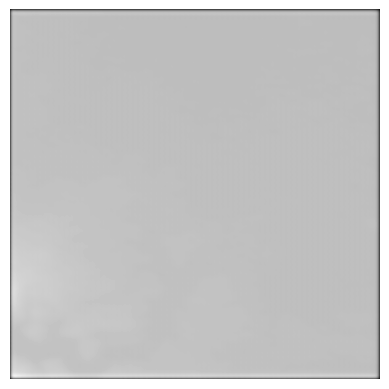

Low resolution image


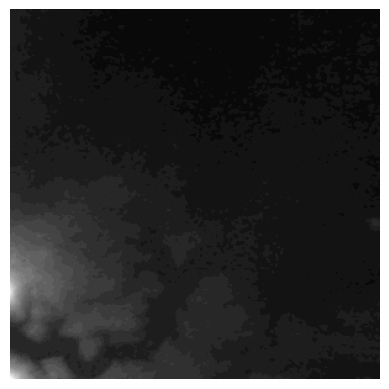

<ipython-input-3-b2cfd50aa680>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1,y2 = torch.tensor(y1,dtype=torch.float32),torch.tensor(y2,dtype=torch.float32)


PSNR: 24.172 SSIM: 0.778

Mse loss calue:  0.004307368770241737 

min -0.36557796597480774 and max 0.9127100706100464 values of predicted_hr
Predicted image:


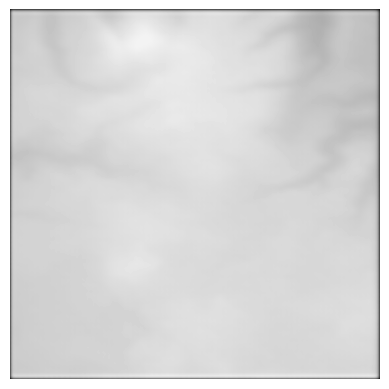

Low resolution image


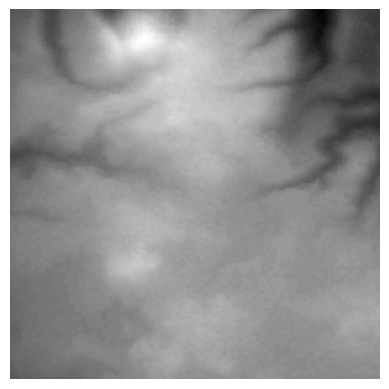

PSNR: 25.680 SSIM: 0.791

Mse loss calue:  0.0040603261440992355 

min -0.35787317156791687 and max 0.9148038029670715 values of predicted_hr
Predicted image:


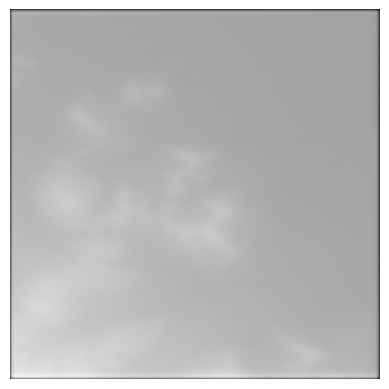

Low resolution image


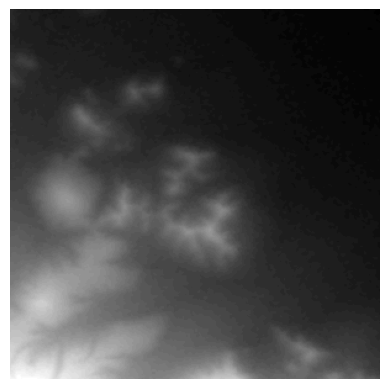

PSNR: 25.554 SSIM: 0.795

Mse loss calue:  0.004623244516551495 

min -0.3440541625022888 and max 0.911808431148529 values of predicted_hr
Predicted image:


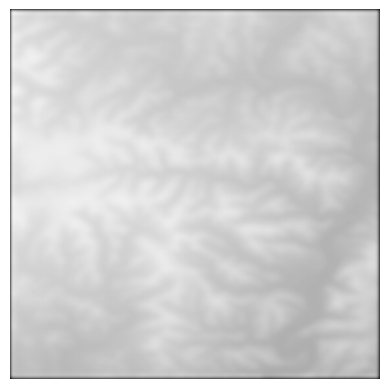

Low resolution image


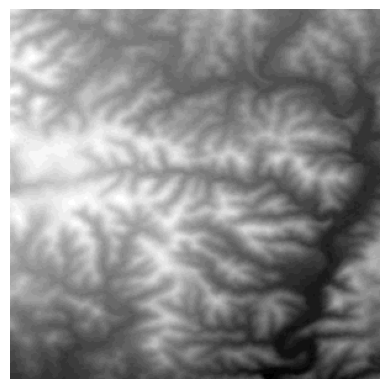

PSNR: 24.600 SSIM: 0.775

Mse loss calue:  0.004491897765547037 

min -0.2677496075630188 and max 0.9111297726631165 values of predicted_hr
Predicted image:


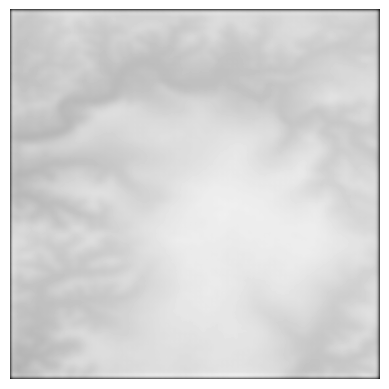

Low resolution image


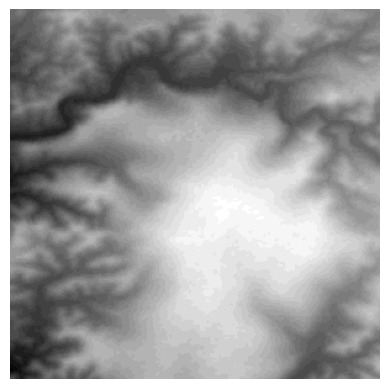

PSNR: 25.472 SSIM: 0.791

Mse loss calue:  0.003587981453165412 

min -0.36603811383247375 and max 0.9132991433143616 values of predicted_hr
Predicted image:


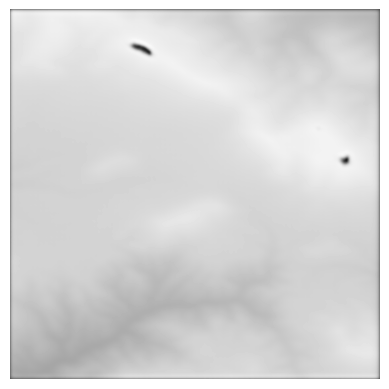

Low resolution image


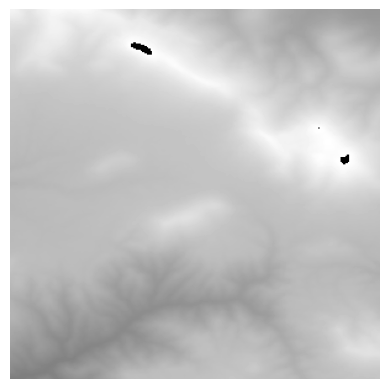

PSNR: 26.039 SSIM: 0.810

Mse loss calue:  0.003610428888350725 

min -0.337075799703598 and max 0.9107818603515625 values of predicted_hr
Predicted image:


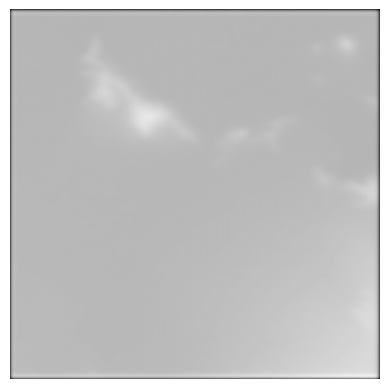

Low resolution image


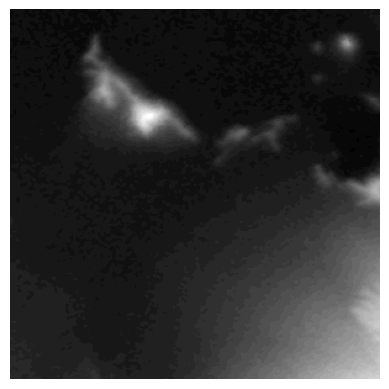

PSNR: 25.124 SSIM: 0.797

Mse loss calue:  0.004092345479875803 

min -0.3738562762737274 and max 0.9164416193962097 values of predicted_hr
Predicted image:


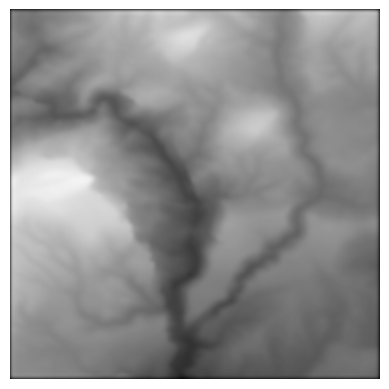

Low resolution image


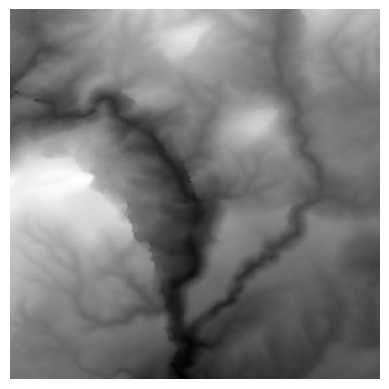

PSNR: 25.673 SSIM: 0.793

Mse loss calue:  0.003725239308550954 

min -0.35581889748573303 and max 0.9143032431602478 values of predicted_hr
Predicted image:


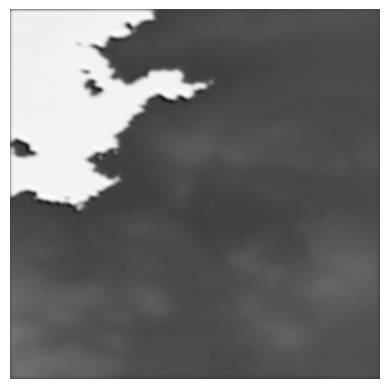

Low resolution image


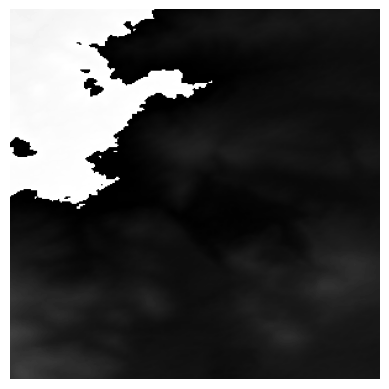

PSNR: 23.983 SSIM: 0.776

Mse loss calue:  0.005266064777970314 

min 0.009236966259777546 and max 0.8963620066642761 values of predicted_hr
Predicted image:


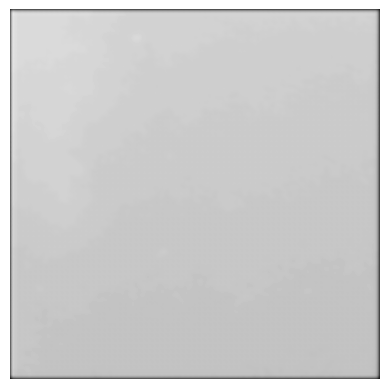

Low resolution image


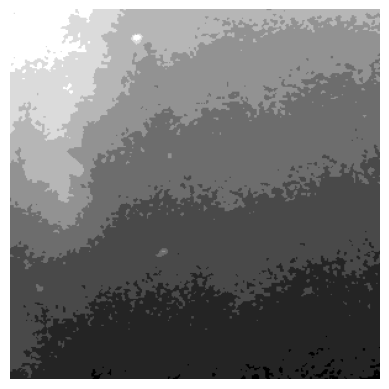

PSNR: 27.169 SSIM: 0.810

Mse loss calue:  0.002274284604936838 

PSNR: 25.347 SSIM: 0.792
 MSE_LOSS: 0.004



In [ ]:

CHECKPOINT_GEN = "/content/drive/My Drive/DEM DATA/austria_dtm/gen3.pth.tar"
CHECKPOINT_DISC = "/content/drive/My Drive/DEM DATA/austria_dtm/disc3.pth.tar"


import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from glob import glob
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt


LOAD_MODEL = True
SAVE_MODEL = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(1, 32).to(DEVICE) # Generator
disc = Discriminator(1, 32).to(DEVICE) # Discriminator

# optimizer for generator and disciriminator, which is responsible for updating
# the weights of the models to minize its loss during training
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001) # learning rate can be changed
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.001) # learning rate can be changed

num_epochs = 10
num_train_batches = float(len(train_loader))
num_test_batches = float(len(test_loader))

if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GEN,
        gen,
        opt_gen,
        0.001,
    )
    load_checkpoint(
        CHECKPOINT_DISC, disc, opt_disc, 0.001,
    )

gen.eval()

# Function to post-process and visualize
def postprocess_and_display(tensor):
    tensor = tensor.squeeze().detach().cpu().numpy()  # Convert to numpy array
    tensor = (tensor + 1) / 2  # Rescale back to [0, 1] if the output was in [-1, 1]
    plt.imshow(tensor, cmap='gray')
    plt.axis('off')
    plt.show()

# MSE loss is defined here
mse_loss = nn.MSELoss()

def calculate_mse_loss(hr, predicted_hr):
    return mse_loss(hr, predicted_hr)

with torch.inference_mode():
    mse_val = 0
    val_psnr = 0
    val_ssim = 0
    for batch, (lr, hr) in enumerate(test_loader):
        lr = lr.to(DEVICE)
        hr = hr.to(DEVICE)
        lr = lr.float()
        predicted_hr = gen(lr)

        min_value = torch.min(predicted_hr).item()
        max_value = torch.max(predicted_hr).item()

        print(f"min {min_value} and max {max_value} values of predicted_hr")

        print("Predicted image:")
        postprocess_and_display(predicted_hr[0])

        print("Low resolution image")
        postprocess_and_display(lr[0])


        #for i in range(0, len(predicted_hr)):
            #postprocess_and_display(predicted_hr[i])
        psnr, ssim = calculate_error(hr, predicted_hr) # I should create high resolution test images as 1200x1200
        val_psnr += psnr
        val_ssim += ssim

        mse = calculate_mse_loss(hr, predicted_hr)
        mse_val += mse.item()
        # Burada bir de diğer mse gibi error fonksiyonlarını kullan.
        # Hem PSNR hem de SSIM losslar kullanılıyor training kısmında
        print(f"PSNR: {psnr:.3f} SSIM: {ssim:.3f}\n")
        print(f"Mse loss calue:  {mse.item()} \n")

    val_psnr /= num_test_batches
    val_ssim /= num_test_batches
    mse_val /= num_test_batches
    print(f"PSNR: {val_psnr:.3f} SSIM: {val_ssim:.3f}\n MSE_LOSS: {mse_val:.3f}\n")

